In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
# %load MLOperationsUtilities.py
def readDataFromCsv(file):
    import pandas as pd
    print ("Reading the file from: ",file)
    df = pd.read_csv(file)
    return df

def loadDataset(paths=['../datasets/files_generated/Personality/study1_features_data.csv',
                      '../datasets/files_generated/Personality/study2_features_data.csv'],target='Neuroticism'):
    for path in paths:
        if 'study1' in path:
            df = readDataFromCsv(path)
            df_temp_1 = df.copy()
            df= df.select_dtypes (['int64','float64']).drop(['VP','age','user_id'],axis=1)
            print('The shape of the data  currently in study1: ',df.shape)
            X_study1,y_study1= df.drop(['Neuroticism', 'Extraversion', 
                                        'Openness', 'Agreeableness','Conscientiousness'],axis=1),df[target]
        if 'study2'in path:
            df = readDataFromCsv(path)
            df_temp_2 = df.copy()
            df = df.select_dtypes(['int64','float64']).drop(['user_id','UserId','VP','Age','Handedness_Score'],axis=1)
            print('The shape of the data  currently in study2: ',df.shape)
            X_study2,y_study2=df.drop(['Neuroticism', 'Extraversion', 'Openness', 'Agreeableness','Conscientiousness'],axis=1),df[target]

    # concat both the studies
    X = pd.concat([X_study1,X_study2])
    y= pd.concat([y_study1,y_study2])
    print('The shape of the data after concating both the studies {}'.format(X.shape))
    print('The shape of the target after concating both the studies {}'.format(y.shape))
    assert df.isnull().values.any()==False, 'Please check for null values'
    df_result={'data':X,'target':y}
    return df_result

In [54]:
def analysePCA(X,y,n_components,cols_to_drop, column_to_analyze='Cond',transformation=False,transformedFeatures=None):
    
    # split the data into train test set
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,shuffle=True)     
    
    X_train = X
    scaler = StandardScaler()
    if transformation==False:
        columns = X_train.drop(cols_to_drop,axis=1).columns
        columns=np.array(columns)
        
        scaler.fit(X_train.drop(cols_to_drop,axis=1))
        X_train_sc=scaler.transform(X_train.drop(cols_to_drop,axis=1))
        #X_test_sc = scaler.transform(X_test.drop(cols_to_drop,axis=1))
        title='Projecting original features in PC dimensions'
    else:
        # drop user_id, sessionNr, cond,App
        # select only normal features
        X_train_temp = X_train.drop(cols_to_drop,axis=1)[transformedFeatures]
        #X_test_temp=X_test.drop(cols_to_drop,axis=1)[transformedFeatures]
        print(X_train_temp.shape)
        
        print("Shape after selecting only transformed features ",X_train_temp.shape)
        scaler.fit(X_train_temp)
        X_train_sc=scaler.transform(X_train_temp)
        #X_test_sc = scaler.transform(X_test_temp)
        
        columns = transformedFeatures
        columns=np.array(columns)
        title='Projecting transformed features in PC dimensions'
        

    pca= PCA(n_components=n_components)
    pca.fit(X_train_sc)
    print('number of principal components:',pca.n_components_)
    # logging.info('number of principal components: {}'.format(pca.n_components_))
    X_train_pca = pca.transform(X_train_sc)
#     X_test_pca = pca.transform(X_train_sc)
    print(X_train_pca.shape)

    # explains the noise variance
    print('Noise Variance:{}'.format(pca.noise_variance_))

    #explains how much variance is captured by each PC. 
    var = pca.explained_variance_ratio_
    # Cumulative variance
    var_cum=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
    print(len(var))
    print('Number of prinicipal components generated for spell:',pca.n_components_)

    #append the result in data frame
    data_spell={'Proportion of Variance Explained':np.round(var,decimals=4),'Cummulative Variance Explained':var_cum,
              'Principal Components':np.arange(1,pca.n_components_+1),
                    'eigenvalues':pca.explained_variance_}
    df_variance_spell = pd.DataFrame(data=data_spell)

    print(var_cum)

    # plot the results
    '''
    Plot the first and second PCs based on cond
    '''
    fig, (ax1,ax2)=plt.subplots(1,2, figsize=(15,8))
    
    X_train_pca = pd.DataFrame(X_train_pca)
    cond=X_train[column_to_analyze]
    cond=cond.reset_index(drop=True)
    data =pd.concat([X_train_pca,cond],axis=1)
    print(data.columns)
    
    sns.scatterplot(x=0,y=1,hue=column_to_analyze,data=data,ax=ax1)
#     sns.scatterplot(x=1,y=2,hue=column_to_analyze,data=data,ax=ax3)
    
#     im = ax1.scatter(X_train_pca[:,1],X_train_pca[:,2],c=X_train[column_to_analyze],cmap='RdBu_r')
   
#     ax1.scatter(X_train_pca[:,1],X_train_pca[:,2])
#     fig.colorbar(im , ax=ax1)
#     ax1.legend(loc=2)
    ax1.set_xlabel('PC1 with {0:.2f}% variance'.format(pca.explained_variance_ratio_[0]*100))
    ax1.set_ylabel('PC2 with {0:.2f}% variance'.format(pca.explained_variance_ratio_[1]*100))
    ax1.set_title(title)

    '''
    Plot the variance explained by the PCs
    '''
    ax2.plot(df_variance_spell['Principal Components'],
                 df_variance_spell['Proportion of Variance Explained'],label='variance',color='blue',linestyle='dashed')
    ax2.plot(df_variance_spell['Principal Components'],
                 df_variance_spell['Cummulative Variance Explained'],label='cummulative variance',
                color='orange')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Variance Explained')

    ax2.set_title('Variance explained by each PC')
    ax2.legend()

    '''
    features contribution by sort the mean in descending order
    '''
    contrib_features_mean = pca.components_.mean(axis=0)
    contrib_features_std=np.square(pca.components_.std(axis=0))

    sort_indices = np.argsort(contrib_features_mean)[::-1]
    print(len(sort_indices))
    contrib_features_mean[:] = contrib_features_mean[sort_indices]
    contrib_features_std[:] = contrib_features_std[sort_indices]
    columns[:]=columns[sort_indices]
#     print("Columns sorted according to the weights in PCs: ",columns)
    
    # store the mean and std in one file with two seperate tabs

    fig,axs = plt.subplots(1,1,figsize=(15, 8),sharex=True)
    axs.plot(contrib_features_mean, '--o', label = 'mean')
    axs.plot(contrib_features_std, '--o', label = 'variance')
    axs.legend(loc='lower right')
    axs.set_ylabel('Feature Contribution')
    axs.set_xticks(np.arange(len(columns)))
    axs.set_xlim([0, 40])
    axs.set_xticklabels(columns,rotation=90)
    axs.set_title('Original distributions')
    fig.suptitle('Feature contributions over all the PC',fontsize=15)

In [113]:
target='Extraversion'
df_study1=pd.read_csv('../datasets/files_generated/Personality/study1_features_data_out_mahalanobis.csv')
df_1_temp = df_study1.copy()
df_study2=pd.read_csv('../datasets/files_generated/Personality/study2_features_data_out_mahalanobis.csv')
df_2_temp = df_study2.copy()
df_study1['sex']=df_study1['sex'].replace('w','f')
df_study1['sex'] = df_study1['sex'].str.upper()
df_1_temp = df_1_temp.select_dtypes(['int64','float64']).drop(['VP','user_id',],axis=1)
df_1_temp['sex']=df_study1['sex']
df_2_temp.rename(columns={'Age':'age'},inplace=True)

df_2_temp = df_2_temp.select_dtypes(['int64','float64']).drop(['user_id','UserId','VP','Handedness_Score'],axis=1)
df_2_temp['sex']=df_study2['sex']

X_study1,y_study1= df_1_temp.drop(['Neuroticism', 'Extraversion', 
                                        'Openness', 'Agreeableness','Conscientiousness'],axis=1),df_study1[target]
X_study2,y_study2= df_2_temp.drop(['Neuroticism', 'Extraversion', 
                                        'Openness', 'Agreeableness','Conscientiousness'],axis=1),df_study2[target]

X = pd.concat([X_study1,X_study2])
y= pd.concat([y_study1,y_study2])
X.head()

,x_location.down_mean,y_location.down_mean,touch.duration_mean,swipe_length_mean,swipe_length.x_mean,swipe_length.y_mean,button_touch_x_location_mean,button_touch_y_location_mean,target_touch_x_location_mean,target_touch_y_location_mean,...,x_location.release_count,y_location.release_count,difference.touch_buttonCenter_x_count,difference.touch_buttonCenter_y_count,touchAccuracy_count,touchAccuracy_x_count,touchAccuracy_y_count,hit_rate,age,sex
0,622.900353,421.775132,0.499118,264.131247,167.896825,183.920635,62.102293,21.364198,60.311929,33.310005,...,567,567,567,567,567,567,567,0.708995,24,F
1,648.706152,398.416885,0.395288,257.332974,154.692408,184.725785,54.870419,19.897906,54.259400,34.117325,...,764,764,764,764,764,764,764,0.675393,20,M
2,616.169481,431.918831,0.444156,248.197721,158.344156,169.777273,42.839610,21.650000,42.813341,33.212456,...,770,770,770,770,770,770,770,0.671429,29,F
3,574.955670,410.657732,0.686598,254.388387,153.901031,179.886598,40.796374,18.192215,41.718932,28.126617,...,485,485,485,485,485,485,485,0.727835,28,F
4,639.398519,404.729630,0.416296,264.404178,161.319259,184.554074,43.452618,17.591034,42.873872,29.818855,...,675,675,675,675,675,675,675,0.648889,23,F


number of principal components: 3
(76, 3)
Noise Variance:0.9974218231379346
3
Number of prinicipal components generated for spell: 3
[0.4123 0.54   0.5894]
Index([0, 1, 2, 'sex'], dtype='object')
181


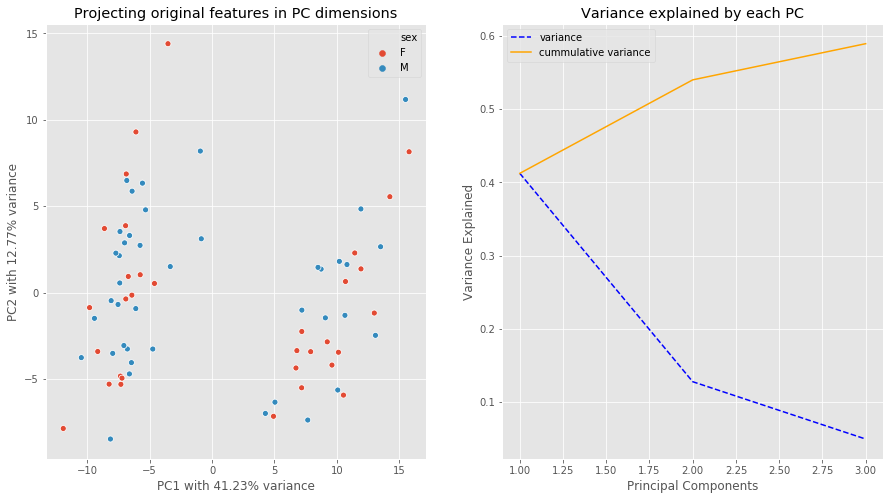

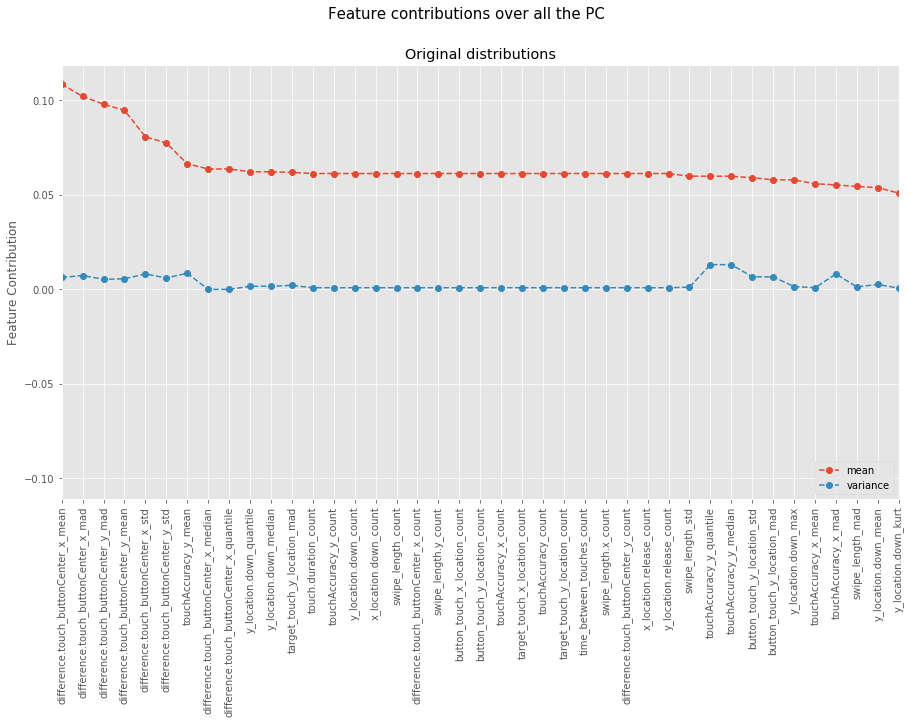

In [115]:
'''original features'''
n_components=0.95
cols_to_drop=['age','sex']


n_components=0.80
# analysePCA(X,y,n_components,cols_to_drop, column_to_analyze='sex',transformation=False)

n_components=3
analysePCA(X,y,n_components,cols_to_drop, column_to_analyze='sex',transformation=False)

current shape: (76, 68)
number of principal components: 2
(76, 2)
Noise Variance:0.6586138162658269
2
Number of prinicipal components generated for spell: 2
[0.2009 0.3067]
Index([0, 1, 'sex'], dtype='object')
66


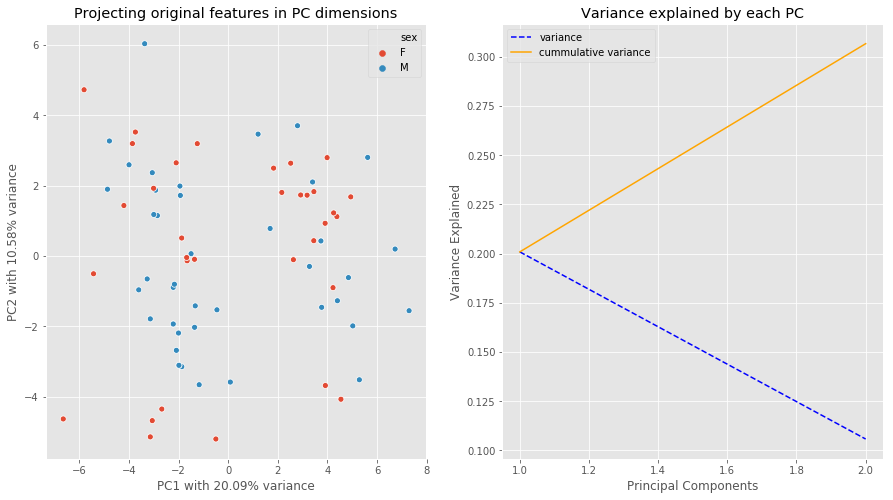

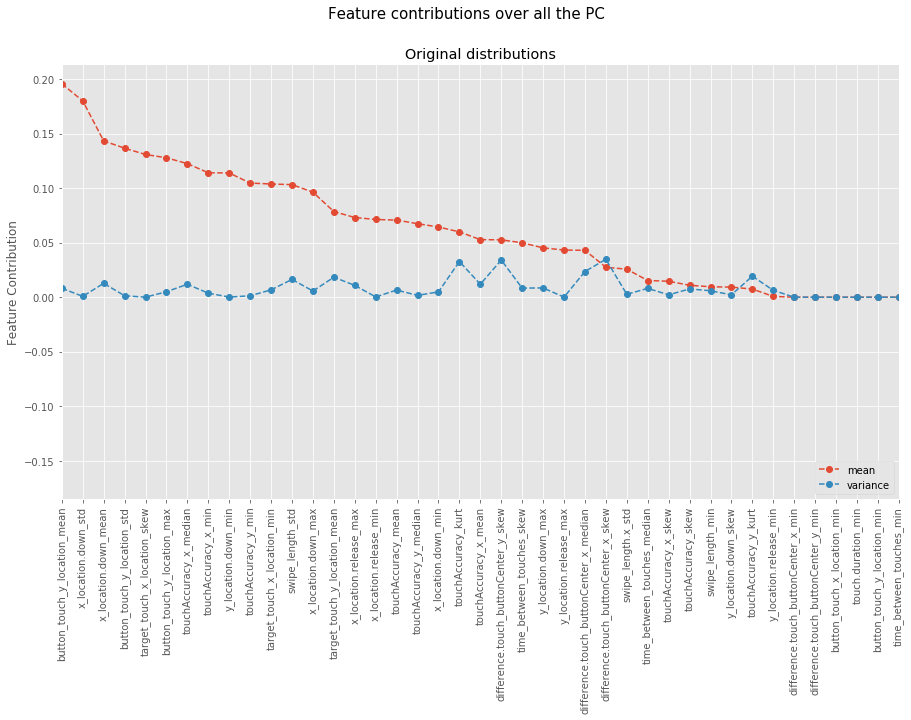

In [106]:
# X = X.loc[:, X.var() != 0.0]
indx= np.where(X.var()==0)
# print(X.columns)
cols = X.iloc[:,indx[0]].columns
X.drop(cols,axis=1)
# print(X.iloc[:,:-1])
# Create correlation matrix
corr_matrix = X.iloc[:,:-2].corr().abs()

# Select upper triangle of correlation matrix
upper_traingle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop_cols = [column for column in upper_traingle.columns if any(upper_traingle[column] >= 0.80)]

# Drop features 
X = X.drop(X[to_drop_cols], axis=1)
print("current shape:",X.shape)



n_components=2
cols_to_drop=['age','sex']
analysePCA(X,y,n_components,cols_to_drop, column_to_analyze='sex',transformation=False)
# X.iloc[:,:-2].head()
# X.loc[:, X.var() != 0.0]

# indx[0]


In [38]:
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.linear_model import Lasso
alpha_space = np.logspace(-2, 2, 100)
#     alpha_space = [0.001,0.01,0.1,1.0,2,3]
param_grid={'alpha':alpha_space}
lasso = Lasso(random_state=32)
scaler=StandardScaler()
X=scaler.fit_transform(X)
pca = PCA(n_components=0.80)
X= pca.fit_transform(X)
scoring={'r2':'r2','mse':'neg_mean_squared_error','mae':'neg_mean_absolute_error'}
search = GridSearchCV(lasso, param_grid, cv=10,n_jobs=-1,scoring=scoring,return_train_score=True,refit='r2')
search.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=32,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.00000e-02, 1.09750e-02, ..., 9.11163e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring={'r2': 'r2', 'mse': 'neg_mean_squared_error', 'mae': 'neg_mean_absolute_error'},
       verbose=0)

In [39]:
search.best_score_

-0.5121390096455121